<a href="https://colab.research.google.com/github/SYEON9/radar_image_predict/blob/main/raining_predict_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# data mount

In [1]:
#drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import zipfile


import glob
import torch
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, ConvLSTM2D, Conv3D
from tensorflow.keras import Model, layers, optimizers

import warnings
warnings.filterwarnings("ignore")

In [3]:
#data load
train_file = zipfile.ZipFile('/content/drive/MyDrive/235646_공공데이터 활용 수력 댐 강우예측 AI 경진대회_data/train.zip')
train_file.extractall('.')

In [4]:
#이미지 가져오기
#train데이터의 이름을 train_files라는 변수에 하나의 리스트로 넣음.
train_files = glob.glob('/content/drive/MyDrive/235646_공공데이터 활용 수력 댐 강우예측 AI 경진대회_data/train/*.npy')
len(train_files) #전체 데이터 개수 확인

62735

# 데이터 학인

In [5]:
#1번째 데이터만 불러와서 데이터를 확인하자.
data_1st = np.load(train_files[0])
data_1st.shape

(120, 120, 5)

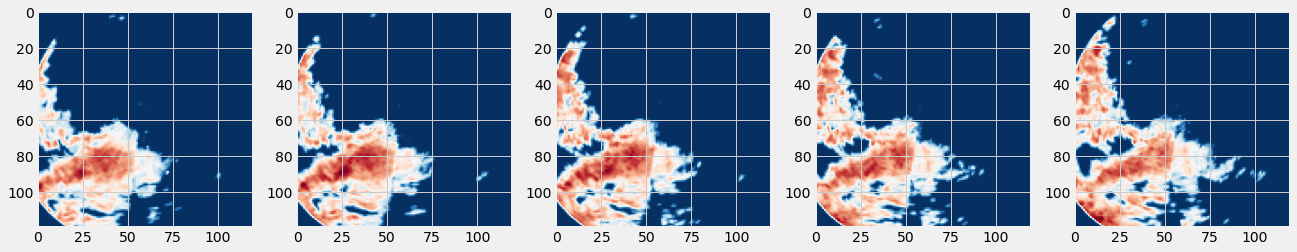

In [15]:
#시각화해서 다시 확인하자. 
#color map 지정
color_map = plt.cm.get_cmap('RdBu')  #"RdBu"색으로 이미지를 칠함. 
color_map = color_map.reversed()  #지정된 색을 뒤집는다. 

#시각화
plt.style.use('fivethirtyeight')  #스타일 시트 지정.
plt.figure(figsize = (20,20)) #창의 크기를 (20, 20)으로 설정. 

for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(data_1st[:,:,i], cmap = color_map)

plt.subplot(1, 5, 5)
plt.imshow(data_1st[:,:,-1], cmap=color_map)
plt.show()

#데이터는 10분 간격의 5개의 이미지로 구성되어 있다. 
#그러나 마지막 데이터는 label이므로 모델을 학습할 때에는 앞의 4개만 사용해야 한다. 

# 데이터 전처리

In [6]:
#데이터 불러오기
#5개의 이미지 데이터를 4개의 train 데이터와 1개의 label 데이터로 분리한다. 
def trainGenerator():
    for file in train_files:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]

        yield (feature, remove_minus)
        
#메모리 문제로 1개의 batch만큼만 올려 처리한다. 
#이미지 3채널을 5채널로 변경
#batch size를 256으로 설정. 
#prefetch를 사용하여 미리 데이터를 가져옴. -> 메모리 대기시간을 줄일 수 있음.
train_data = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([62735,10,120,120,4]),tf.TensorShape([62735,10,120,120,1])))
train_dataset = train_data.batch(256).prefetch(1)
train_d = train_data

# 모델링

In [17]:
#model
inp = layers.Input(shape = (10,120,120,4))

x = layers.ConvLSTM2D(32, kernel_size=(5,5), padding = 'same', return_sequences = True, activation = 'relu',)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(64, kernel_size=(5,5), padding = 'same', return_sequences = True, activation = 'relu',)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(64, kernel_size=(5,5), padding = 'same', return_sequences = True, activation = 'relu',)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(64, kernel_size=(5,5), padding = 'same', return_sequences = True, activation = 'relu',)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(filters = 1, kernel_size = (5,5,5), activation = 'sigmoid', padding='same')(x)



In [16]:
from tensorflow.keras.layers import MaxPooling3D, Dropout, UpSampling3D

In [22]:
#model2
inp = layers.Input(shape = (10,120,120,4))

#Encoder
net1 = layers.ConvLSTM2D(32, kernel_size=(5,5), padding = 'same', return_sequences = True)(inp)
max_pool1 = MaxPooling3D(pool_size=(2,2,2), strides = 2, padding = 'same')(net1)
bn1 = layers.BatchNormalization()(max_pool1)
dp2 = Dropout(0.2)(bn1)

net2 = layers.ConvLSTM2D(64, kernel_size=(5,5), padding = 'same', return_sequences = True)(dp2)
max_pool2 = MaxPooling3D(pool_size=(2,2,2), strides = 2, padding = 'same')(net2)
bn2 = layers.BatchNormalization()(max_pool2)
dp2 = Dropout(0.2)(bn2)

net3 = layers.ConvLSTM2D(128, kernel_size=(5,5), padding = 'same', return_sequences = True)(dp2)
max_pool3 = MaxPooling3D(pool_size=(2,2,2), strides = 2, padding = 'same')(net3)
bn3 = layers.BatchNormalization()(max_pool3)
dp3 = Dropout(0.2)(bn3)

#decoder
net4 = layers.ConvLSTM2D(128, kernel_size=(5,5), padding = 'same', return_sequences = True)(dp3)
up1 = UpSampling3D((2,2,2))(net4)

net5 = layers.ConvLSTM2D(64, kernel_size = (5,5), padding = 'same', return_sequences=True)(up1)
up2 = UpSampling3D((2,2,2))(net5)

net6 = layers.ConvLSTM2D(32, kernel_size = (5,5), padding = 'same', return_sequences=True)(up2)
up3 = UpSampling3D((2,2,2))(net6)

#output
out = layers.Conv3D(filters = 1, kernel_size = (5,5,5), activation = 'sigmoid', padding='same',
                    data_format = 'channels_last')(up3)



In [23]:
model = keras.models.Model(inp,out)
model.compile(loss = 'mae', optimizer = 'adam')

In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 16, 120, 120, 4)] 0         
_________________________________________________________________
conv_lst_m2d_27 (ConvLSTM2D) (None, 16, 120, 120, 32)  115328    
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 8, 60, 60, 32)     0         
_________________________________________________________________
conv_lst_m2d_28 (ConvLSTM2D) (None, 8, 60, 60, 64)     614656    
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 4, 30, 30, 64)     0   

In [25]:
model.fit(train_d, epochs=1, verbose=1)

ValueError: ignored

# 새 섹션

In [ ]:
#data path setting
path = '/content'

In [ ]:
#zip 해제
zip_file = zipfile.ZipFile(path+'/train.zip')
zip_file.extractall('.')

In [ ]:
zip_file = zipfile.ZipFile(path+'/test.zip')
zip_file.extractall('./test/')

데이터 전처리 및 모델 구축에 필요한 패키지 불러오기

# 새 섹션

In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, Input
from tensorflow.keras import Model

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch

In [ ]:
# train data 생성
train_files = glob.glob('/content/train/*.npy')
len(train_files)
train_files = np.array(train_files)

In [ ]:
def trainGenerator():
    for file in tr_file:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)        
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]



        yield (feature, remove_minus)

def valGenerator():
    for file in val_file:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)        
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]


        yield (feature, remove_minus)

In [ ]:
# 최초 베이스라인
def base_model(input_layer, start_neurons):
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)

    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer


In [ ]:
import os

In [ ]:
import gc
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42)
for fold, (train, val) in enumerate(kf.split(train_files)):
  #print(type(val))
  val_file = train_files[val]
  tr_file = train_files[train]
  

  train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))
  train_dataset = train_dataset.shuffle(256)

  train_dataset = train_dataset.batch(128).prefetch(1)

  val_dataset = tf.data.Dataset.from_generator(valGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))
  val_dataset = val_dataset.batch(128).prefetch(1)

  

  input_layer = Input((120, 120, 4))
  output_layer = base_model(input_layer,64)

  model = Model(input_layer, output_layer)
  adam = tf.keras.optimizers.Adam()
  model.compile(optimizer=adam, loss='mae')


  callbacks = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, verbose=0, mode='min',
    min_delta=0.0001, cooldown=0, min_lr=0
  )

  sv = tf.keras.callbacks.ModelCheckpoint(
        os.path.join(path,f'{fold}-rain.h5'), monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')

  model.fit(train_dataset, epochs = 1, verbose=1, validation_data=val_dataset, callbacks=[callbacks, sv])

  del model
  gc.collect()